In [1]:
# =============================================================================
# Import necessary libraries and modules
# =============================================================================
import torch
import numpy as np
import pandas as pd
import time
import os
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import sys

sys.path.append('..')

# Import custom modules
from config import ExplainConfig
from data.data_utils import (
    load_genotype_data, apply_missing_mask, encode_genotype_to_categorical,
    simulate_phenotype, GenotypeDataset, PhenotypeDataset, prepare_pretraining_data,
    preprocess_phenotype_data
)
from model.model_utils import (
    CMDAutoEncoder, CMDPhenotypePredictor, train_autoencoder, evaluate_autoencoder,
    train_phenotype_predictor, evaluate_phenotype_predictor, set_random_seed,
    load_pretrained_weights, pretrain_autoencoder
)
from train.cross_train import cross_validation_phenotype_prediction
from train.evaluation_utils import (
    calculate_encoder_feature_correlations, integrated_gradients_batch,
    calculate_integrated_gradients, calculate_mean_importance, calculate_std_importance,
    calculate_combined_importance, calculate_fourier_filtered_importance,
    apply_kalman_filter, plot_feature_importance, calculate_roc_curves,
    plot_roc_comparison, calculate_runtime_summary,
    print_final_results
)

# Initialize configuration
config = ExplainConfig()
start_time = time.time()


In [ ]:
# =============================================================================
# Data loading and preprocessing
# =============================================================================

# Load data
input_name = './dataset/simulate_geno.csv'
df_ori = load_genotype_data(input_name, max_rows=config.MAX_ROWS)
print(f"Genotype data shape: {df_ori.shape}")

Genotype data shape: (873, 20000)


In [3]:
# =============================================================================
# Data preprocessing
# =============================================================================

# Apply data preprocessing
mask_data = apply_missing_mask(df_ori, config.MISSING_RATIO)
print(f"Missing ratio: {config.MISSING_RATIO}")

Missing ratio: 0.0


In [4]:
# Create DataFrame for masked data
mask_data_copy = pd.DataFrame(mask_data, index=df_ori.index, columns=df_ori.columns)
print(f"Masked data shape: {mask_data_copy.shape}")

Masked data shape: (873, 20000)


In [5]:
# Encode genotype data to categorical format
df_onehot = encode_genotype_to_categorical(mask_data)
df_onehot_no_miss = encode_genotype_to_categorical(df_ori.to_numpy())
print(f"Encoded data shape: {df_onehot.shape}")

Encoded data shape: (873, 20000, 3)


In [6]:
# Verify data shape
print(f"Encoded data shape: {df_onehot.shape}")

Encoded data shape: (873, 20000, 3)


In [7]:
# =============================================================================
# Data splitting and model initialization
# =============================================================================

# Prepare pre-training data
train_loader, valid_loader = prepare_pretraining_data(
    df_onehot, df_onehot_no_miss, 
    test_size=0.1, random_seed=config.RANDOM_SEED
)

In [8]:
# =============================================================================
# Device configuration
# =============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [9]:
# =============================================================================
# Generate phenotype data using the same method as explain_mamba_10-21-2.ipynb
# =============================================================================
def create_phone_type(x, num_local=3, 
                     local=[(20,300), (10000,10300), (17000,17300)],
                     num_effect=[50,60,50],
                     effect=[0.3,0.3,0.3],
                     h=1.8):
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    
    effects = [(np.random.rand(num_effect[i])*effect[i]).tolist() for i in range(len(num_effect))]
    effects = [sorted(i[:len(i)//2])+sorted(i[len(i)//2:], reverse=True) for i in effects]
    effects = [item for sublist in effects for item in sublist]
    
    
    local = [np.random.randint(local[i][0], local[i][1], num_effect[i]).tolist() for i in range(len(local))]
    local = [item for sublist in local for item in sublist]
    
    a = np.zeros(x.shape[1])
    a[local] = effects
    
    out_ = x.astype(float).dot(a)  
    # out_ = out_ + np.random.randn(x.shape[0])*((1-h)/h)*np.var(out_)
    
    return out_, a

# Generate phenotype data using the same method as explain_mamba_10-21-2.ipynb
mask_data_copy_float = mask_data_copy.astype(float)
simulated_phenotype, effect_vector = create_phone_type(mask_data_copy_float)

print(f"Effect vector shape: {effect_vector.shape}")
print(f"Number of effect positions: {np.sum(effect_vector > 0)}")
print(f"Effect vector statistics:")
print(f"  Mean effect size: {np.mean(effect_vector[effect_vector > 0]):.4f}")
print(f"  Max effect size: {np.max(effect_vector):.4f}")
print(f"  Min effect size: {np.min(effect_vector[effect_vector > 0]):.4f}")
print(f"Phenotype statistics:")
print(f"  Mean: {np.mean(simulated_phenotype):.4f}")
print(f"  Std: {np.std(simulated_phenotype):.4f}")
print(f"  Min: {np.min(simulated_phenotype):.4f}")
print(f"  Max: {np.max(simulated_phenotype):.4f}")


Effect vector shape: (20000,)
Number of effect positions: 141
Effect vector statistics:
  Mean effect size: 0.1432
  Max effect size: 0.2986
  Min effect size: 0.0017
Phenotype statistics:
  Mean: 2.0964
  Std: 0.7803
  Min: 0.3729
  Max: 5.0728


In [10]:
random_seed = 42
train_X, valid_X = train_test_split(df_onehot, test_size=0.1, random_state=random_seed)
# train_X_un_misss, valid_X_un_misss = train_test_split(df_onehot_no_miss, test_size=0.1, random_state=random_seed)

train_dataset = GenotypeDataset(train_X, missing_perc=0)
valid_dataset = GenotypeDataset(valid_X,missing_perc=0)
train_loader = DataLoader(train_dataset ,batch_size=32,num_workers=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset),num_workers=4 ,shuffle=False)

train_X.shape

(785, 20000, 3)

In [11]:
# =============================================================================
# Phenotype simulation (using imported functions)
# =============================================================================
# Note: simulate_phenotype is already imported from data_utils
# This function is defined in data_utils.py and imported at the top of the notebook
phenotype_file_path = "simulate_pheno.txt"
if os.path.exists(phenotype_file_path):
    # Load from file
    with open(phenotype_file_path, 'r') as f:
        phenotype_lines = f.readlines()

In [12]:
print(f"Phenotype data shape: {simulated_phenotype.shape}")
simulated_phenotype.shape

Phenotype data shape: (873,)


(873,)

In [13]:
# =============================================================================
def load_or_use_simulated_phenotype(file_path, simulated_phenotype):
    """Load phenotype data or use simulated data"""
    if os.path.exists(file_path):
        phenotype_df = pd.read_csv(file_path, header=None, names=["value"])
        phenotype_values = phenotype_df.values.ravel()
        print(f"Loaded phenotype from file: {phenotype_df.shape}")
    else:
        phenotype_values = simulated_phenotype
        print(f"Using simulated phenotype: {phenotype_values.shape}")
    
    return phenotype_values

phenotype_file_path = "pheno_clean.txt"
phenotype_data = load_or_use_simulated_phenotype(phenotype_file_path, simulated_phenotype)
print(f"Final phenotype shape: {phenotype_data.shape}")

Using simulated phenotype: (873,)
Final phenotype shape: (873,)


In [14]:
# =============================================================================
def prepare_phenotype_prediction_data(phenotype_values, genotype_dataframe):
    """Prepare data for phenotype prediction"""
    phenotype_2d = phenotype_values.reshape(-1, 1) if len(phenotype_values.shape) == 1 else phenotype_values
    
    genotype_encoded = encode_genotype_to_categorical(genotype_dataframe)
    
    assert genotype_encoded.shape[0] == phenotype_2d.shape[0], "Sample count mismatch"
    
    print(f"Data preparation completed:")
    print(f"  Genotype shape: {genotype_encoded.shape}")
    print(f"  Phenotype shape: {phenotype_2d.shape}")
    
    return genotype_encoded, phenotype_2d

genotype_for_prediction, phenotype_for_prediction = prepare_phenotype_prediction_data(
    phenotype_data, mask_data_copy
)

Data preparation completed:
  Genotype shape: (873, 20000, 3)
  Phenotype shape: (873, 1)


In [15]:
print(f"Encoded Genotype shape: {genotype_for_prediction.shape}")
genotype_for_prediction.shape

Encoded Genotype shape: (873, 20000, 3)


(873, 20000, 3)

In [16]:
# =============================================================================
# Preprocess phenotype data and prepare for cross-validation
# =============================================================================

# Create phenotype DataFrame for preprocessing
phenotype_df = pd.DataFrame(phenotype_for_prediction, index=mask_data_copy.index)
phenotype_df.columns = ['phenotype']

# Preprocess phenotype data
genotype_encoded, phenotype_normalized, phenotype_scaler = preprocess_phenotype_data(
    phenotype_df, mask_data_copy, phenotype_column=0,normalize_phenotype=True
)

print(f"Preprocessed genotype shape: {genotype_encoded.shape}")
print(f"Preprocessed phenotype shape: {phenotype_normalized.shape}")

# =============================================================================
# Execute 10-fold cross-validation
# =============================================================================

# Set random seed for reproducibility
set_random_seed(config.RANDOM_SEED)

# Execute 10-fold cross-validation
all_best_correlations = cross_validation_phenotype_prediction(
    genotype_encoded, phenotype_normalized, phenotype_scaler, device, config=config
)

# Create empty fold_losses for visualization (since cross_validation_phenotype_prediction doesn't return it)
fold_losses = [[] for _ in range(config.N_SPLITS)]

# 保存交叉验证的训练索引，用于后续梯度计算
from sklearn.model_selection import KFold
kf = KFold(n_splits=config.N_SPLITS, shuffle=True, random_state=config.RANDOM_SEED)
fold_train_indices = []
for fold, (train_index, test_index) in enumerate(kf.split(genotype_encoded)):
    fold_train_indices.append(train_index)

print("\n===== Cross-validation completed =====")
print("Best correlations for each fold:", np.round(all_best_correlations, 4))


Phenotype column name: phenotype
After normalization - Mean: 0.0000, Std: 1.0000
Preprocessed genotype shape: (873, 20000, 3)
Preprocessed phenotype shape: (873,)

========== Cross-validation Fold 1/10 ==========
🔄 Fold 1: Using random initialization (pre-training disabled)


/root/miniconda3/lib/python3.8/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


Training epoch: 1 [0/785 (0%)]	Loss: 0.737863
Training epoch: 1 [160/785 (20%)]	Loss: 1.531261
Training epoch: 1 [320/785 (40%)]	Loss: 1.402176
Training epoch: 1 [480/785 (60%)]	Loss: 1.382557
Training epoch: 1 [640/785 (80%)]	Loss: 1.216860
=========> Epoch: 1 Average loss: 1.1441
Correlation coefficient: 0.6699
✅ Epoch 1: New best correlation = 0.6699
Training epoch: 2 [0/785 (0%)]	Loss: 0.453676
Training epoch: 2 [160/785 (20%)]	Loss: 0.641032
Training epoch: 2 [320/785 (40%)]	Loss: 0.655141
Training epoch: 2 [480/785 (60%)]	Loss: 0.657957
Training epoch: 2 [640/785 (80%)]	Loss: 0.590418
=========> Epoch: 2 Average loss: 0.5610
Correlation coefficient: 0.6971
✅ Epoch 2: New best correlation = 0.6971
Training epoch: 3 [0/785 (0%)]	Loss: 0.297696
Training epoch: 3 [160/785 (20%)]	Loss: 0.290594
Training epoch: 3 [320/785 (40%)]	Loss: 0.298685
Training epoch: 3 [480/785 (60%)]	Loss: 0.401102
Training epoch: 3 [640/785 (80%)]	Loss: 0.175175
=========> Epoch: 3 Average loss: 0.3282
Corre

In [17]:
# =============================================================================
print(f"Missing ratio: {config.MISSING_RATIO}")
print(f"Mean correlation: {np.mean(all_best_correlations):.4f}")
print(f"Std: {np.std(all_best_correlations):.4f}")
print(f"Best correlations per fold: {all_best_correlations}")

Missing ratio: 0.0
Mean correlation: 0.8599
Std: 0.0285
Best correlations per fold: [0.8594132063042088, 0.7920692945457916, 0.8530683340742296, 0.8447074245435692, 0.8466471492106439, 0.8707978717370758, 0.8620951501787693, 0.8969451063090047, 0.8939563807670601, 0.8795379284919637]


In [18]:
# =============================================================================
# Integrated gradients functions (using imported functions)
# =============================================================================
# Note: integrated_gradients_batch and calculate_integrated_gradients are already imported from evaluation_utils
# These functions are defined in evaluation_utils.py and imported at the top of the notebook

print("Loading best model for feature importance analysis...")
best_model = CMDPhenotypePredictor(
    in_channels=config.IN_CHANNELS,
    out_channels=config.OUT_CHANNELS,
    kernel_size=config.KERNEL_SIZE,
    stride=config.STRIDE,
    d_state=config.D_STATE
).to(device)

best_model.load_state_dict(torch.load("model/fold_1_best_model.pth"))

fold_1_train_indices = fold_train_indices[0]  
train_genotype = genotype_for_prediction[fold_1_train_indices]
train_phenotype = phenotype_for_prediction[fold_1_train_indices]

train_dataset = PhenotypeDataset(train_genotype, train_phenotype)

all_gradients = calculate_integrated_gradients(
    best_model, train_dataset, 
    batch_size=config.IG_BATCH_SIZE, 
    steps=config.IG_STEPS, 
    device=device
)

if all_gradients is not None:
    print(f"Completed! Processed {all_gradients.shape[0]} samples")
    print(f"Gradient tensor shape: {all_gradients.shape}")

Loading best model for feature importance analysis...


Calculating integrated gradients: 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]

Completed! Processed 785 samples
Gradient tensor shape: torch.Size([785, 3, 20000])


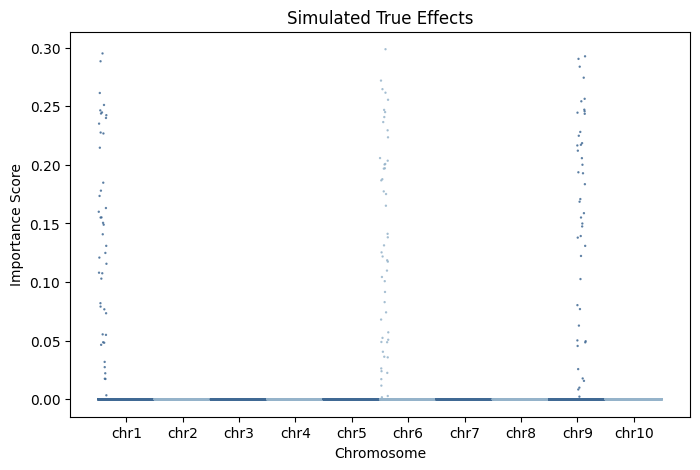

In [19]:
# =============================================================================
# Feature importance visualization (using imported functions)
# =============================================================================
# Note: create_chromosome_colors and plot_feature_importance are already imported from evaluation_utils
# These functions are defined in evaluation_utils.py and imported at the top of the notebook

plot_feature_importance(effect_vector, title="Simulated True Effects", show_plot=True)

Mean importance shape: (20000,)


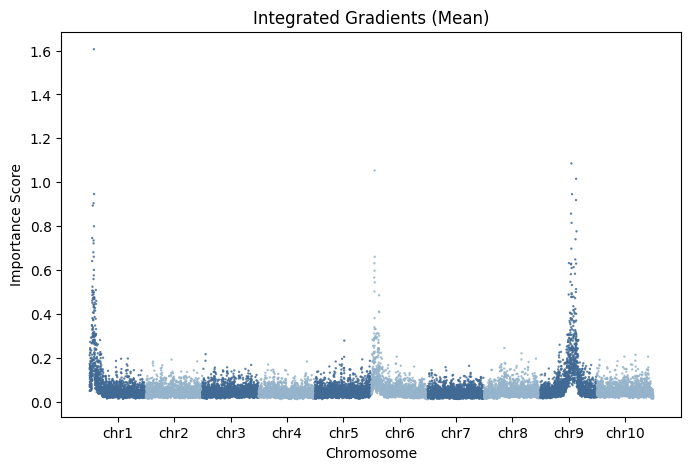

In [20]:
# =============================================================================
# Mean importance calculation (using imported functions)
# =============================================================================
# Note: calculate_mean_importance is already imported from evaluation_utils
# This function is defined in evaluation_utils.py and imported at the top of the notebook

mean_importance = calculate_mean_importance(all_gradients)
print(f"Mean importance shape: {mean_importance.shape}")

plot_feature_importance(mean_importance, title='Integrated Gradients (Mean)', show_plot=True)

Std importance shape: (20000,)


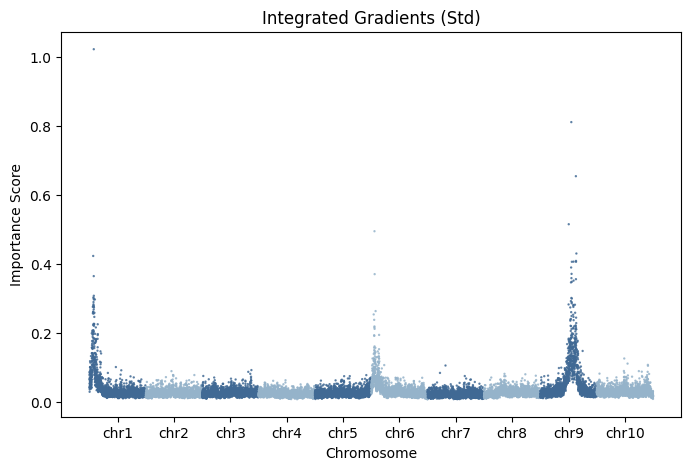

In [21]:
# =============================================================================
# Std importance calculation (using imported functions)
# =============================================================================
# Note: calculate_std_importance is already imported from evaluation_utils
# This function is defined in evaluation_utils.py and imported at the top of the notebook

std_importance = calculate_std_importance(all_gradients)
print(f"Std importance shape: {std_importance.shape}")

plot_feature_importance(std_importance, title='Integrated Gradients (Std)', show_plot=True)

Combined importance shape: (20000,)


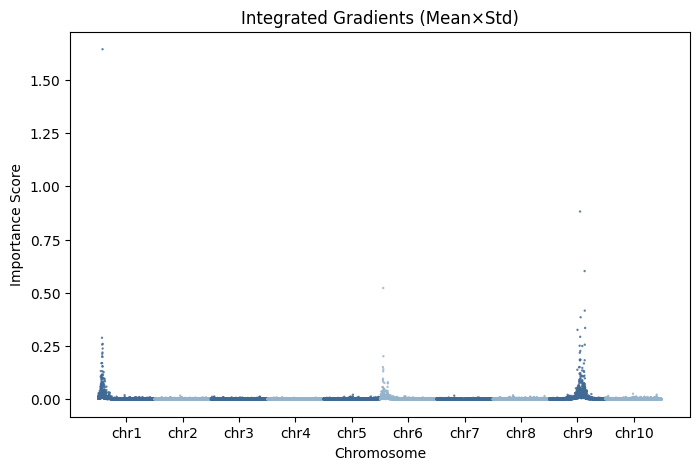

In [22]:
# =============================================================================
# Combined importance calculation (using imported functions)
# =============================================================================
# Note: calculate_combined_importance is already imported from evaluation_utils
# This function is defined in evaluation_utils.py and imported at the top of the notebook

combined_importance = calculate_combined_importance(mean_importance, std_importance)
print(f"Combined importance shape: {combined_importance.shape}")

plot_feature_importance(combined_importance, title='Integrated Gradients (Mean×Std)', show_plot=True)

Original frequencies: 10001
Retained frequencies: 9818
Filter ratio: 1.83%
Fourier importance shape: (20000,)


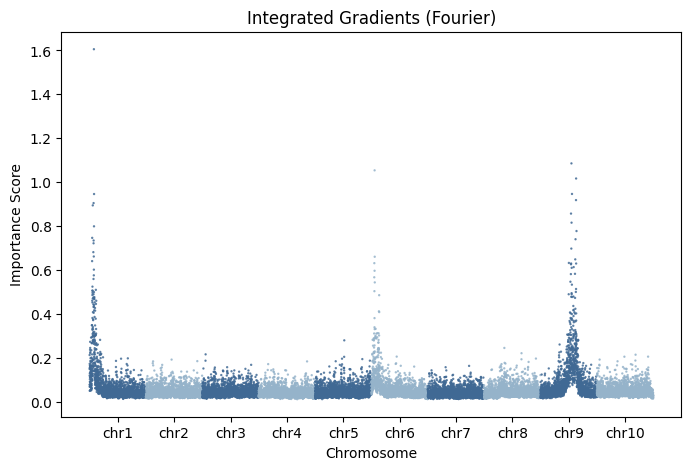

In [23]:
# =============================================================================
# Fourier filtered importance calculation (using imported functions)
# =============================================================================
# Note: calculate_fourier_filtered_importance is already imported from evaluation_utils
# This function is defined in evaluation_utils.py and imported at the top of the notebook

fourier_importance, frequency_response = calculate_fourier_filtered_importance(
    all_gradients, threshold=0.7
)
print(f"Fourier importance shape: {fourier_importance.shape}")

plot_feature_importance(fourier_importance, title='Integrated Gradients (Fourier)', show_plot=True)

Kalman importance shape: (20000,)


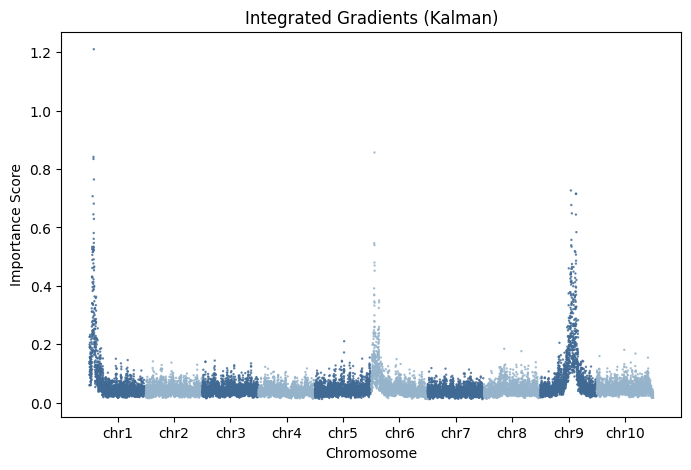

In [24]:
# =============================================================================
# Kalman filter application (using imported functions)
# =============================================================================
# Note: apply_kalman_filter is already imported from evaluation_utils
# This function is defined in evaluation_utils.py and imported at the top of the notebook

kalman_importance = apply_kalman_filter(mean_importance, dt=50.0, 
                                        process_noise=1e-2, measurement_noise=150)
print(f"Kalman importance shape: {kalman_importance.shape}")

plot_feature_importance(kalman_importance, title='Integrated Gradients (Kalman)', show_plot=True)

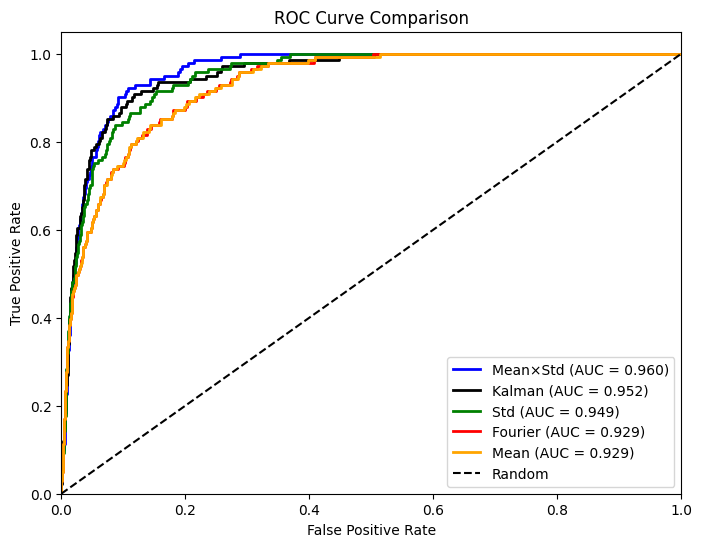

In [29]:
# =============================================================================
# ROC curve analysis (using imported functions)
# =============================================================================
# Note: calculate_roc_curves and plot_roc_comparison are already imported from evaluation_utils
# These functions are defined in evaluation_utils.py and imported at the top of the notebook

importance_methods = {
    'combined': combined_importance,
    'kalman': kalman_importance,
    'std': std_importance,
    'fourier': fourier_importance,
    'mean': mean_importance,
}

roc_results = calculate_roc_curves(effect_vector, importance_methods)

plot_roc_comparison(roc_results, save_path="ROC_comparison.pdf")